In [2]:
from matplotlib import pylab
import numpy as np

# import sys
# sys.path.insert(0,"/Users/claresinger/Research/PySDM")
# print(sys.path)

from PySDM import Formulae
from PySDM.physics import si
from PySDM.physics import constants_defaults as const
from atmos_cloud_sim_uj_utils import show_plot
from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark

In [19]:
cases = {'BetaCary': AerosolBetaCaryophylleneDark()}
aer = AerosolBetaCaryophylleneDark()

formulae_bulk = Formulae(surface_tension='Constant')

formulae_ovad = Formulae(
    surface_tension='CompressedFilmOvadnevaite',
    constants={
        'sgm_org': 34.77 * si.mN / si.m,
        'delta_min': 1.73 * si.nm  # TODO #604 0.2 in the paper, but 0.1 matches the paper plots
    }
)

formulae_ruehl = Formulae(
    surface_tension='CompressedFilmRuehl',
    constants={
        'RUEHL_nu_org': aer.aerosol_modes_per_cc[0]['nu_org'],
        'RUEHL_A0': 115e-20 * si.m * si.m,
        'RUEHL_C0': 6e-7,
        'RUEHL_m_sigma': 0.3e17 * si.J / si.m**2,
        'RUEHL_sgm_min': 34.77 * si.mN / si.m
    }
)

## from Ryan
# A0=115, ln(C0)=-4, and m=0.3
# MW_inorg = 132;  # ammonium sulfate
# MW_H2O = 0.018015;
# VHF_org = 1;     # vant hoff factor
# VHF_inorg = 2.6;
# pw = 997;
# rho_inorg = 1.77 * 1e3;  # kg m-3 
# MW_inorg = 0.13214;       # kg mol-1
# rho_org = 905;             # kg m-3
# MW_org = 0.20436;         # kg mol-1

formulae_sl = Formulae(
    surface_tension='SzyszkowskiLangmuir',
    constants={
        'RUEHL_nu_org': aer.aerosol_modes_per_cc[0]['nu_org'],
        'RUEHL_A0': 115e-20 * si.m * si.m,
        'RUEHL_C0': 6e-7,
        'RUEHL_sgm_min': 34.77 * si.mN / si.m
    }
)

r_wet = np.logspace(np.log(50 * si.nm), np.log(2000 * si.nm), base=np.e, num=100)
r_dry = 50 * si.nm
v_wet = formulae_ovad.trivia.volume(r_wet)
v_dry = formulae_ovad.trivia.volume(r_dry)
T=300 * si.K
r_wet_ticks_nm = (100,300, 500, 1000, 2000)
lines = {'bulk': '-', 'CompressedFilmOvadnevaite': '--', 'CompressedFilmRuehl': ':', 'SzyszkowskiLangmuir': '-.'}

### Surface tension

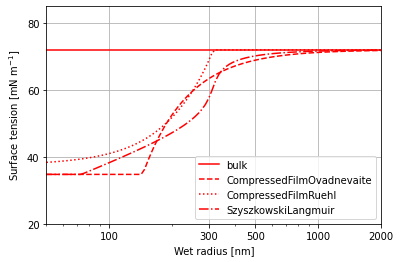

In [21]:
for label, formulae in {'bulk': formulae_bulk, 'CompressedFilmOvadnevaite': formulae_ovad, 'CompressedFilmRuehl': formulae_ruehl, 'SzyszkowskiLangmuir': formulae_sl}.items():
    for k, v in cases.items():
        sigma = np.zeros(len(v_wet))
        if label == "CompressedFilmRuehl":
            for i, vw in enumerate(v_wet):
                sigma[i] = formulae.surface_tension.sigma(T, vw, v_dry, v.aerosol_modes_per_cc[0]['f_org'])
        else:
            sigma = formulae.surface_tension.sigma(T, v_wet, v_dry, v.aerosol_modes_per_cc[0]['f_org'])
                    
        if type(sigma) != type(v_wet):
            sigma = np.ones(len(v_wet)) * sigma
        pylab.plot(r_wet / si.nm, sigma / (si.mN / si.m), label=label, color=v.color, linestyle=lines[label])

pylab.grid()
pylab.xscale('log')
pylab.xticks(r_wet_ticks_nm, r_wet_ticks_nm)
yticks = (20, 40, 60, 80)
pylab.yticks(yticks, yticks)
pylab.xlim(r_wet[0] / si.nm, r_wet[-1] / si.nm)
pylab.ylim(20, 85)
pylab.xlabel('Wet radius [nm]')
pylab.ylabel('Surface tension [mN m$^{-1}$]')
pylab.legend(loc=4)
#show_plot()
pylab.show()

### Kohler curves

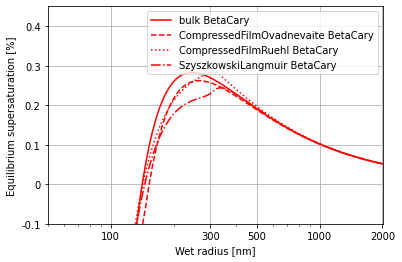

In [22]:
rd3 = r_dry**3

dat = np.zeros((len(r_wet), 5))
dat[:,0] = r_wet
i = 1

for label, formulae in {'bulk': formulae_bulk, 'CompressedFilmOvadnevaite': formulae_ovad, 'CompressedFilmRuehl': formulae_ruehl, 'SzyszkowskiLangmuir': formulae_sl}.items():
    for k, v in cases.items():
        sigma = np.ones(len(v_wet))
        if label == "CompressedFilmRuehl":
            for j,vw in enumerate(v_wet):
                sigma[j] = formulae.surface_tension.sigma(T, vw, v_dry, v.aerosol_modes_per_cc[0]['f_org'])
        else:
            sigma = formulae.surface_tension.sigma(T, v_wet, v_dry, v.aerosol_modes_per_cc[0]['f_org'])
        
        RH_eq = formulae.hygroscopicity.RH_eq(r_wet, T, v.aerosol_modes_per_cc[0]['kappa'][label], rd3, sigma)
        pylab.plot(
            r_wet / si.nm, 
            (RH_eq - 1)*100, 
            label=f"{label} {k}", 
            color=v.color, 
            linestyle=lines[label]
        )
        dat[:,i] = (RH_eq - 1)*100
        i += 1
pylab.grid()
pylab.xscale('log')
pylab.xticks(r_wet_ticks_nm, r_wet_ticks_nm)
pylab.xlabel('Wet radius [nm]')
pylab.xlim(r_wet[0] / si.nm, r_wet[-1] / si.nm)
pylab.ylabel('Equilibrium supersaturation [%]')
yticks = (-.1, 0, .1, .2, .3, .4)
pylab.yticks(yticks, yticks)
pylab.ylim(yticks[0], .45)
pylab.legend()
#show_plot()
pylab.show()

#print(dat)
#np.savetxt("Ryan_kohler.csv", dat, delimiter=',', fmt='%.4e', header="r wet (m), SS (bulk), SS (film)")

### Critical radius

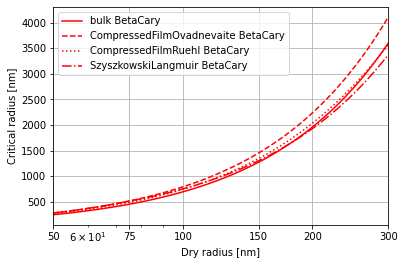

In [23]:
r_dry = np.logspace(np.log(50 * si.nm), np.log(300 * si.nm), base=np.e, num=100)
v_dry = formulae_ovad.trivia.volume(r_dry)
rd3 = r_dry**3

for label, formulae in {'bulk': formulae_bulk, 'CompressedFilmOvadnevaite': formulae_ovad, 'CompressedFilmRuehl': formulae_ruehl, 'SzyszkowskiLangmuir': formulae_sl}.items():
    for k, v in cases.items():
        if label == "CompressedFilmRuehl":
            sigma = np.ones(len(v_wet))
            for j,vw in enumerate(v_wet):
                sigma[j] = formulae.surface_tension.sigma(T, v_wet[j], v_dry[j], v.aerosol_modes_per_cc[0]['f_org'])
        else:
            sigma = formulae.surface_tension.sigma(T, v_wet, v_dry, v.aerosol_modes_per_cc[0]['f_org'])
        rcrit = formulae.hygroscopicity.r_cr(v.aerosol_modes_per_cc[0]['kappa'][label], rd3, T, sigma)
        
        pylab.plot(
            r_dry / si.nm, 
            rcrit / si.nm, 
            label=f"{label} {k}", 
            color=v.color, 
            linestyle=lines[label]
        )
pylab.grid()
pylab.xscale('log')
r_dry_ticks_nm = (50, 75, 100, 150, 200, 300)
pylab.xticks(r_dry_ticks_nm, r_dry_ticks_nm)
pylab.xlabel('Dry radius [nm]')
pylab.xlim(r_dry[0] / si.nm, r_dry[-1] / si.nm)
pylab.ylabel('Critical radius [nm]')
#yticks = (-.1, 0, .1, .2, .3)
#pylab.yticks(yticks, yticks)
#pylab.ylim(yticks[0], .35)
pylab.legend()
pylab.show()
#show_plot()

### Effective Hygroscopicity, $\kappa_{eff}$

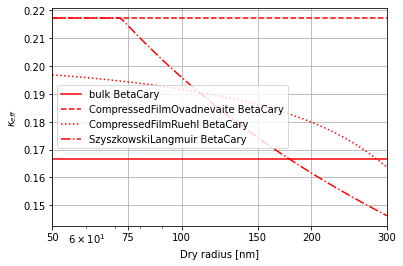

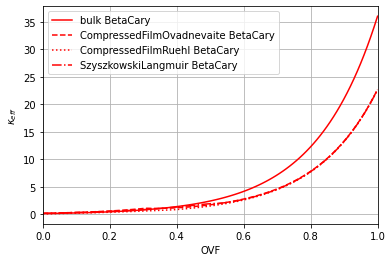

In [25]:
r_dry = np.logspace(np.log(50 * si.nm), np.log(300 * si.nm), base=np.e, num=100)
v_dry = formulae_ovad.trivia.volume(r_dry)
rd3 = r_dry**3

for label, formulae in {'bulk': formulae_bulk, 'CompressedFilmOvadnevaite': formulae_ovad, 'CompressedFilmRuehl': formulae_ruehl, 'SzyszkowskiLangmuir': formulae_sl}.items():
    for k, v in cases.items():
        if label == "CompressedFilmRuehl":
            sigma = np.ones(len(v_wet))
            for j,vw in enumerate(v_wet):
                sigma[j] = formulae.surface_tension.sigma(T, v_wet[j], v_dry[j], v.aerosol_modes_per_cc[0]['f_org'])
        else:
            sigma = formulae.surface_tension.sigma(T, v_wet, v_dry, v.aerosol_modes_per_cc[0]['f_org'])
        rcrit = formulae.hygroscopicity.r_cr(v.aerosol_modes_per_cc[0]['kappa'][label], rd3, T, sigma)
        kap_eff = (2 * rcrit**2) / (3 * r_dry**3 * const.Rv * T * const.rho_w) * const.sgm_w
        
        pylab.plot(
            r_dry / si.nm, 
            kap_eff, 
            label=f"{label} {k}", 
            color=v.color, 
            linestyle=lines[label]
        )
pylab.grid()
pylab.xscale('log')
pylab.xticks(r_dry_ticks_nm, r_dry_ticks_nm)
pylab.xlabel('Dry radius [nm]')
pylab.xlim(r_dry[0] / si.nm, r_dry[-1] / si.nm)
pylab.ylabel('$\kappa_{eff}$')
pylab.legend()
pylab.show()
#show_plot()

#####################

r_dry = 50 * si.nm
v_dry = formulae_ovad.trivia.volume(r_dry)
f_org = np.linspace(1e-6, 1, 100)

for label, formulae in {'bulk': formulae_bulk, 'CompressedFilmOvadnevaite': formulae_ovad, 'CompressedFilmRuehl': formulae_ruehl, 'SzyszkowskiLangmuir': formulae_sl}.items():
    for k, v in cases.items():
        if label == "CompressedFilmRuehl":
            sigma = np.ones(len(v_wet))
            for j,vw in enumerate(v_wet):
                sigma[j] = formulae.surface_tension.sigma(T, v_wet[j], v_dry, f_org[j])
        else:
            sigma = formulae.surface_tension.sigma(T, v_wet, v_dry, f_org[j])
        rcrit = formulae.hygroscopicity.r_cr(v.aerosol_modes_per_cc[0]['kappa'][label], rd3, T, sigma)
        kap_eff = (2 * rcrit**2) / (3 * r_dry**3 * const.Rv * T * const.rho_w) * const.sgm_w
        
        pylab.plot(
            f_org, 
            kap_eff, 
            label=f"{label} {k}", 
            color=v.color, 
            linestyle=lines[label]
        )
pylab.grid()
pylab.xlabel('OVF')
pylab.xlim([0,1])
pylab.ylabel('$\kappa_{eff}$')
pylab.legend()
pylab.show()
#show_plot()

### Aerosol size distribution

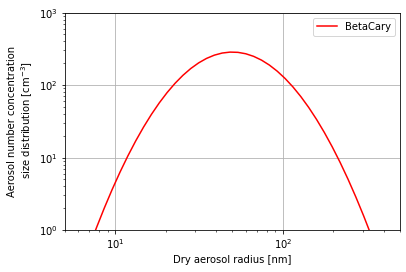

In [26]:
x = np.logspace(np.log(5 * si.nm), np.log(1000 * si.nm), base=np.e)
for k, v in cases.items():
    spec = v.aerosol_modes_per_cc[0]['spectrum']
    pylab.loglog(x / si.nm, spec.size_distribution(x)*x / si.cm**-3, label=k, color=v.color)
pylab.ylim(1, 1000)
pylab.xlim(5, 500)
pylab.legend()
pylab.grid()
pylab.xlabel('Dry aerosol radius [nm]')
pylab.ylabel('Aerosol number concentration\n size distribution [cm$^{-3}$]')
pylab.show()
#show_plot()